In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

In [2]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = []
        self.labels = []
        self.classes = []

        for file in os.listdir(root_dir):
            if file.endswith('.npy'):
                self.filepaths.append(os.path.join(root_dir, file))
                label = file.split('_')[0]
                if label not in self.classes:
                    self.classes.append(label)
                self.labels.append(self.classes.index(label))

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        file_path = self.filepaths[idx]
        image = np.load(file_path)
        
        # Normalize the image with exception handling
        min_val = image.min()
        max_val = image.max()
        if max_val - min_val != 0:
            image = (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]
        else:
            image = np.zeros_like(image)
        
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255]
        
        image = Image.fromarray(image).convert('RGB')  # Convert to RGB
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# 데이터 디렉터리 설정 및 클래스 데이터 수 확인
data_dir = 'C:/Users/SSAFY/Desktop/augmented_combined_features'
filepaths = [file for file in os.listdir(data_dir) if file.endswith('.npy')]
labels = [file.split('_')[0] for file in filepaths]
label_counts = Counter(labels)
print(label_counts)

Counter({'AUG': 2376, 'ACE': 2348, 'M762': 1936, 'SCAR': 1824, 'M416': 1732, 'AKM': 1320})


In [4]:
# 데이터 증강 및 전처리 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
])

In [5]:
# 데이터셋 로드 및 분할
dataset = MelSpectrogramDataset(root_dir=data_dir, transform=transform)

# 데이터셋 분할
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


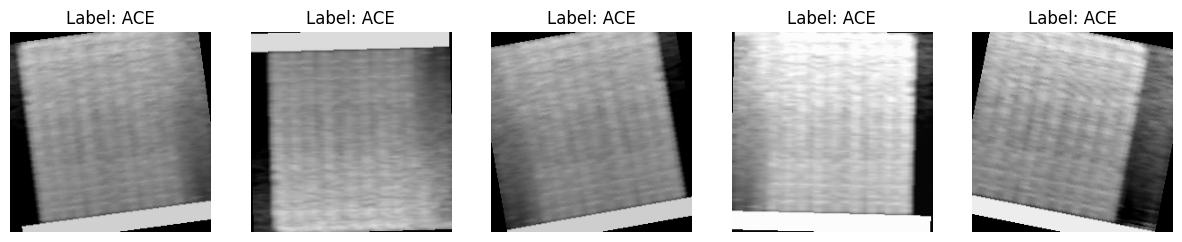

In [6]:
# 샘플 데이터 시각화 함수
def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        sample = dataset[i]
        image, label = sample
        if image is None:
            continue
        image = image.permute(1, 2, 0)  # 채널 위치 변경 (C, H, W) -> (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {dataset.classes[label]}')
        axes[i].axis('off')
    plt.show()

show_samples(dataset)

In [7]:
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# 모델 정의
class GunshotClassifier(nn.Module):
    def __init__(self, num_classes):
        super(GunshotClassifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [9]:
# 클래스 수 정의
num_classes = len(set(labels))  # 전체 클래스 수 확인
model = GunshotClassifier(num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

c:\Users\SSAFY\anaconda3\envs\sound\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SSAFY\anaconda3\envs\sound\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GunshotClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [10]:
# 클래스 가중치 설정
class_weights = torch.tensor([1/label_counts[cls] for cls in sorted(label_counts.keys())], dtype=torch.float)
class_weights = class_weights / class_weights.sum()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 전체 모델 파라미터 사용
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 학습률 스케줄러

num_epochs = 30
best_accuracy = 0.0
train_losses = []
val_accuracies = []

In [11]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix(loss=running_loss / ((progress_bar.n + 1) * batch_size))

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'new_model.pth')

    scheduler.step()  # 학습률 스케줄러 업데이트

Epoch 1/30:   0%|          | 0/325 [00:45<?, ?it/s]

In [ ]:
# 학습 손실 및 검증 정확도 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# 모델 평가 및 혼동 행렬 생성
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(dataset.classes), yticklabels=sorted(dataset.classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()